In [1]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)
df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))

100%|██████████| 13404/13404 [00:05<00:00, 2441.50it/s]


In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    # Создает круговую маску изображения, с требуемым радиусом
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    # Получает граффик высот пятна
    m = np.zeros((15))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-2))
        m[r//2] = np.sum(mask * (img-100.4)) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m


def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(100, 120), bins=20)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    height_map = get_height_map(img)
    spector = np.concatenate([std_img, np.array(kurtosis(height_map)).reshape(-1), sum_img])
    #spector = np.concatenate([std_img, np.array(kurtosis(height_map)).reshape(-1), sum_img])
    #spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

def get_bright_sum(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.98)#112
    return np.sum(img[gaussian_mask]-100.4)/1000

In [4]:
def get_random_noise_hist(img, hist_range=(80, 140), bins=60):
    mask = ~create_circular_mask(250, 250, radius=30)
    img = img * mask
    return np.histogram(img, range=hist_range, bins=bins)[0] / np.sum(mask)


def get_histogram_map(img, radius_0=8, radius_1=15):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(80, 140), bins=60)[0] / np.sum(mask)
    
    return m

In [5]:
random_noise_hist = np.sum(Parallel(n_jobs=c.NUM_CORES)(delayed(get_random_noise_hist)(img, hist_range=(80, 140), bins=60) for img in tqdm(df[df.t==1]['img_250'])), axis=0)

100%|██████████| 6646/6646 [00:03<00:00, 1810.90it/s]


In [44]:
random_noise_hist = np.sum(Parallel(n_jobs=c.NUM_CORES)(delayed(get_random_noise_hist)(img, hist_range=(80, 140), bins=60) for img in tqdm(df[df.t==1]['img_250'])), axis=0) / len(df[df.t==1]['img_250'])

100%|██████████| 6646/6646 [00:02<00:00, 2467.41it/s]


In [ ]:
plt.bar(np.arange(80, 140, 1), random_noise_hist, width = 0.8, color='b')
plt.bar(np.arange(80, 140, 1), get_random_noise_hist(df[df.t==1]['img_250'][1]), width = 0.8, color='r', alpha=0.5)
plt.show()

In [ ]:
plt.bar(np.arange(80, 140, 1), random_noise_hist, width = 0.8, color='b')
plt.bar(np.arange(80, 140, 1), get_histogram_map(df[df.t==1]['img_80'][0]), width = 0.8, color='r', alpha=0.5)
plt.show()

In [ ]:
random_noise_hist * p0

In [189]:
def probability_density_normal_distribution(x, sigma=1, mu=1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

def probability_density(x, r, sigma_pos=1, k_pos=1, sigma_eng=1, k_eng=1):
    M_r = probability_density_normal_distribution(r, sigma=sigma_pos, mu=0) * k_pos
    
    return probability_density_normal_distribution(x, sigma=sigma_eng, mu=M_r) * k_eng

In [ ]:
probability_density(np.arange(0, 10, 1), np.arange(0, 10, 1).reshape(-1, 1))

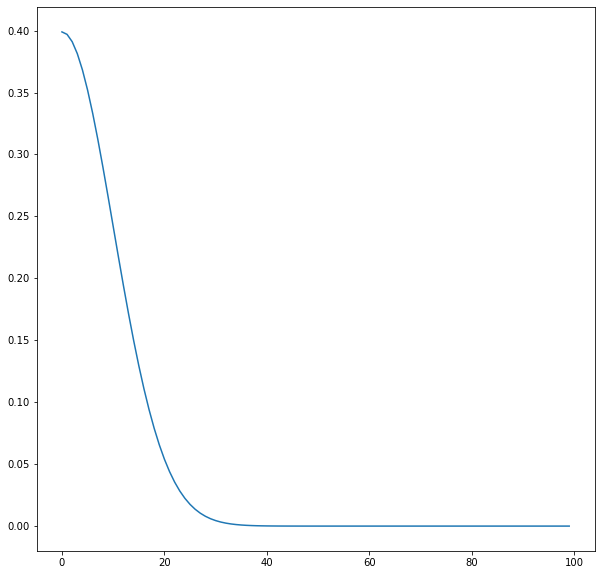

In [187]:
plt.plot(probability_density_normal_distribution(np.arange(0, 10, 0.1), sigma=1, mu=0))

In [172]:
img_hist = get_histogram_map(df[df.t==1]['img_80'][0], 11, 13)

0.464311245426248


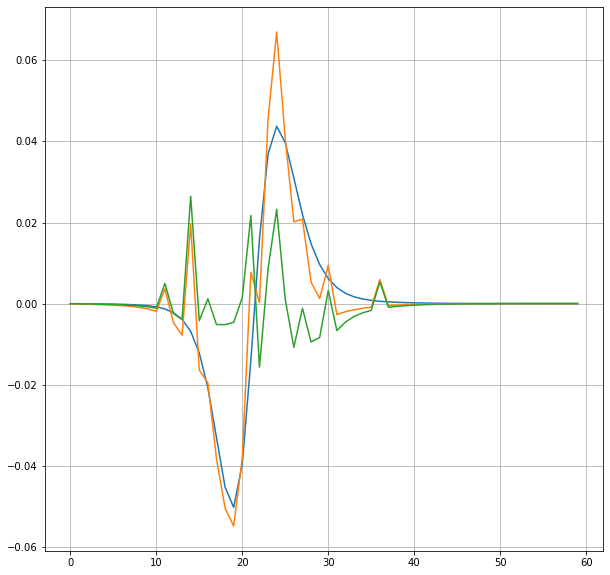

In [173]:
p0 = 0.9
p1 = 0.5
M = []
for i in range(10):
    M.append(np.roll(random_noise_hist * p0, i+1))
M = np.array(M)

X = np.power(np.ones(10) * p1, np.arange(0, 10, 1))
X /= np.sum(X)
Y = np.sum(M * X.reshape(-1, 1), axis=0) - random_noise_hist * p0

error = img_hist - random_noise_hist - Y
plt.plot(Y)
plt.plot(img_hist - random_noise_hist)
plt.plot(error)
plt.grid()
print(np.sum(np.abs(Y)))

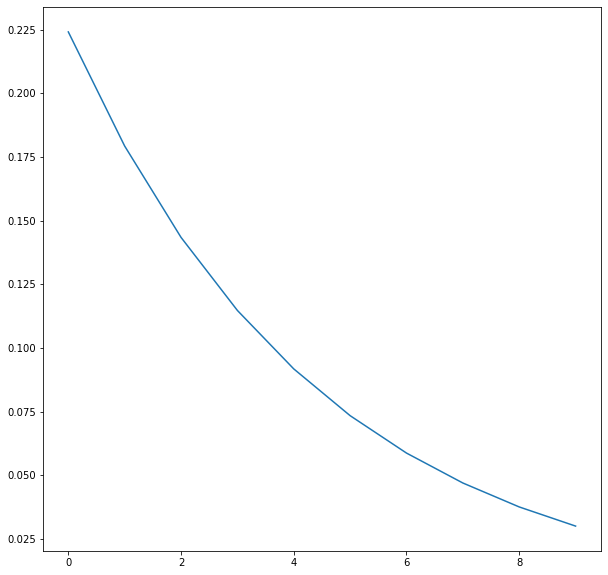

In [149]:
X = np.power(np.ones(10) * 0.8, np.arange(0, 10, 1))
X /= np.sum(X)
plt.plot(X)

In [6]:
imgs = np.array(df[(df.t==1)&(df.e==6)]['img_250'].to_list())
imgs = np.transpose(imgs, (1, 2, 0))

In [52]:
hists = []
for r in range(16):
    mask = create_circular_mask(250, 250, radius=r+2) * (~create_circular_mask(250, 250, radius=r))
    
    mask = mask.reshape(250, 250, 1)
    mask = (mask * np.ones((250, 250, imgs.shape[2]))).astype(bool)
    
    hist, bins = np.histogram(imgs[mask], range=(80, 180), bins=100)
    
    hists.append(hist/np.sum(mask))
hists = np.array(hists)

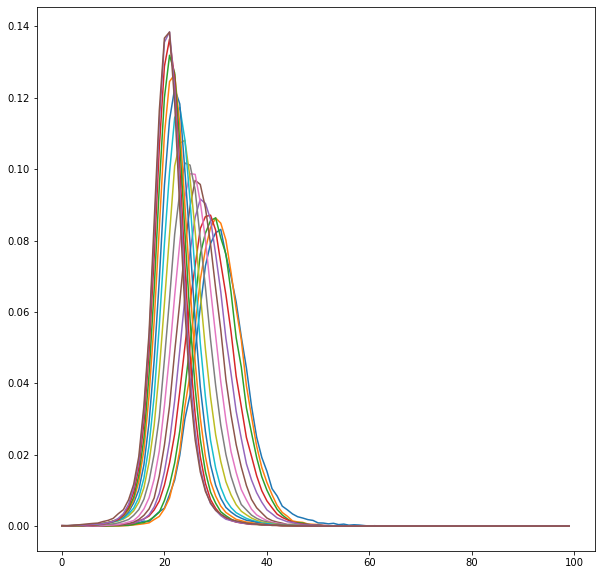

In [59]:
plt.plot(np.transpose(hists, (1, 0)))
plt.show()

In [7]:
df['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df['img_250'])))
df['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df['img_250'])))

df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

df['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df['img_250']))
df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

100%|██████████| 9028/9028 [00:03<00:00, 2762.55it/s]


In [8]:
df['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:44<00:00, 201.41it/s]


In [9]:
df.head()

,t,e,img_250,img_80,circular_ratio,bright_sum,spector
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899..."
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651..."
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459..."
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546..."
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931...."


In [45]:
def get_histogram_matrix(img, max_r):
    hists = []
    for r in range(max_r):
        mask = create_circular_mask(80, 80, radius=r+2) * (~create_circular_mask(80, 80, radius=r))
        hist, bins = np.histogram(img[mask], range=(80, 180), bins=100)
        hists.append(hist/np.sum(mask))
    return np.array(hists)# * np.arange(1, max_r+1).reshape(-1, 1)

In [46]:
mean_hist_matrix * np.arange(1, 17).reshape(-1, 1)

array([[0.        , 0.        , 0.        , ..., 0.00062189, 0.00062189,
        0.00124378],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00248756,
        0.00124378],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00373134,
        0.        ],
       ...,
       [0.02437811, 0.02437811, 0.03250415, ..., 0.        , 0.        ,
        0.        ],
       [0.00912557, 0.05475341, 0.0273767 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05970149, 0.039801  , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
df['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df['img_80']))

100%|██████████| 9028/9028 [00:03<00:00, 2895.45it/s]


In [48]:
mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==1)]['hist_matrix'])
df['error_t1e1'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==6)]['hist_matrix'])
df['error_t1e6'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==20)]['hist_matrix'])
df['error_t1e20'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==3)]['hist_matrix'])
df['error_t0e3'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==10)]['hist_matrix'])
df['error_t0e10'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df['hist_matrix'])

In [49]:
df

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.009588,0.004290,0.013948,0.004973,0.010453
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.015609,0.014470,0.005449,0.015102,0.009165
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014706,0.012888,0.006242,0.013506,0.007334
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.015071,0.013634,0.005318,0.014339,0.007484
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.015566,0.014443,0.006022,0.015088,0.009771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394,0,3,"[[94.0, 107.0, 97.0, 97.0, 101.0, 97.0, 101.0,...","[[101.92, 100.3, 97.72, 106.64, 99.520004, 99....",0.884146,3.268998,"[40.46708679199219, -1.2326699568996422, 12787...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007989,0.004497,0.014739,0.004103,0.010993
13396,0,3,"[[102.0, 99.0, 102.0, 101.0, 101.0, 101.0, 97....","[[105.020004, 98.8, 103.6, 110.32, 99.94, 98.6...",0.937304,3.569998,"[40.59738540649414, -1.2370356048577642, 12826...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.008584,0.004778,0.014726,0.004113,0.010414
13397,0,3,"[[98.0, 100.0, 100.0, 100.0, 98.0, 102.0, 100....","[[101.380005, 99.200005, 101.86, 108.78, 100.2...",0.937304,3.802998,"[40.64213562011719, -1.2284171988470858, 12841...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.008636,0.004956,0.014727,0.004317,0.010598
13398,0,3,"[[107.0, 98.0, 97.0, 101.0, 99.0, 98.0, 100.0,...","[[99.24, 100.200005, 96.18, 103.98, 97.32, 99....",0.878419,3.220398,"[40.63188934326172, -1.2772980134486802, 12839...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.008382,0.004726,0.014504,0.004635,0.010692


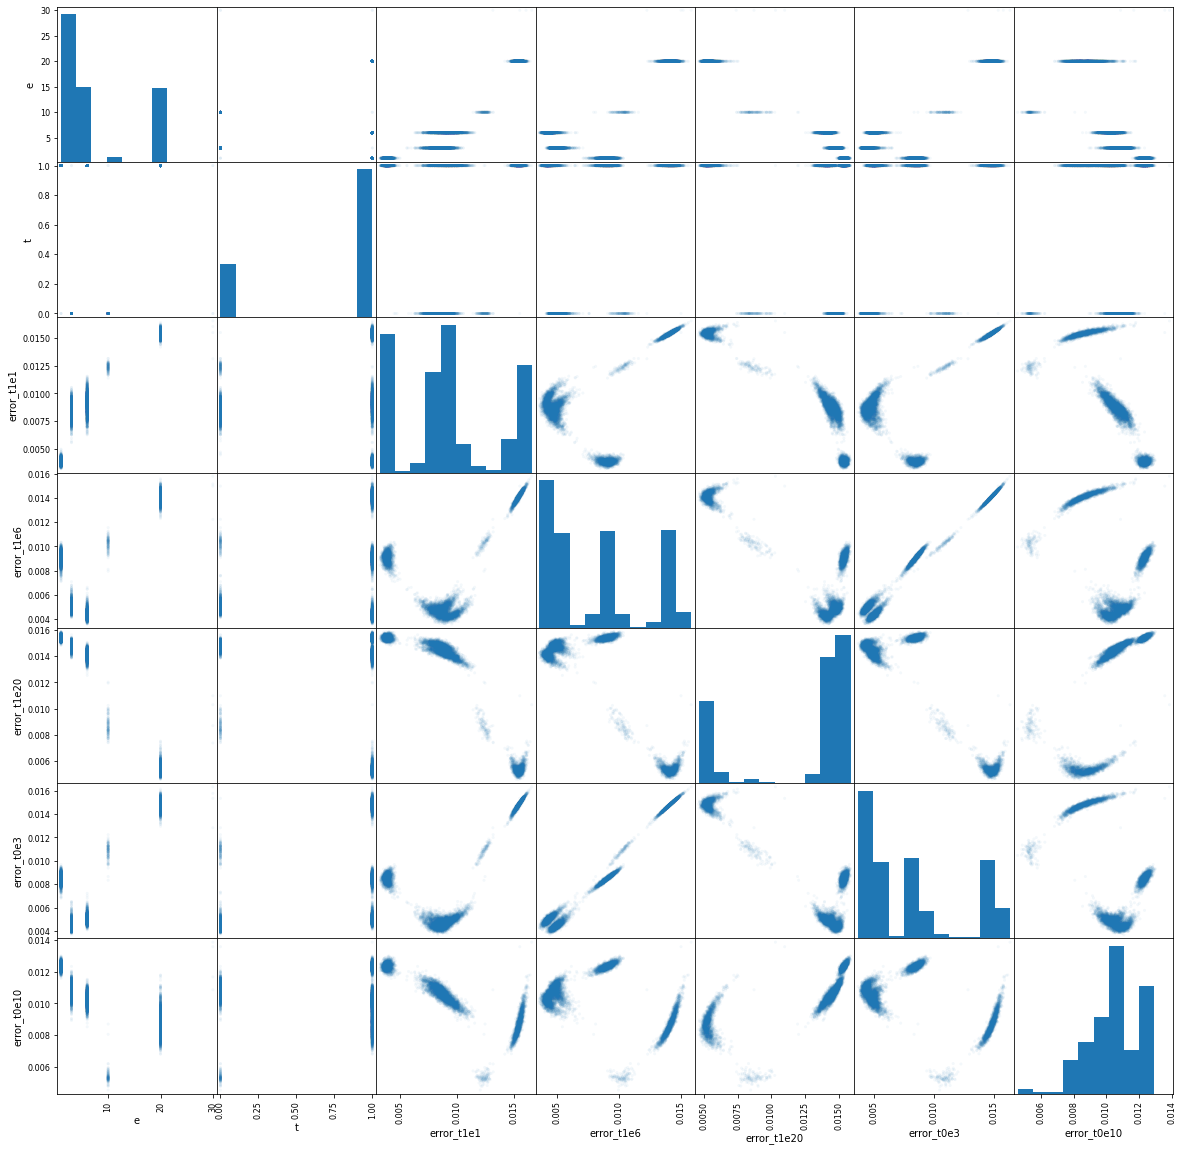

In [50]:
scatter_matrix(df[['e', 't', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']], alpha=0.05, figsize=(20, 20));

In [51]:
x = df[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()

x = np.concatenate([df['spector'].to_numpy().tolist(), x], axis=1)
y = df.t.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [52]:
particle_types_model = CatBoostClassifier(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train), y_train), roc_auc_score(particle_types_model.predict(x_test), y_test))

0.9994941831057158 0.999268688530963


0.9994941831057158 0.999268688530963

In [53]:
particle_types_model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9994941831057158 0.999268688530963


0.9994941831057158 0.999268688530963

In [54]:
particle_types_model = LinearRegression().fit(x_train, y_train)
particle_types_model.score(x_train, y_train)


print(roc_auc_score(particle_types_model.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model.predict(x_test)>0.5, y_test))

0.9965376562113499 0.9970495659880614


0.9965376562113499 0.9970495659880614

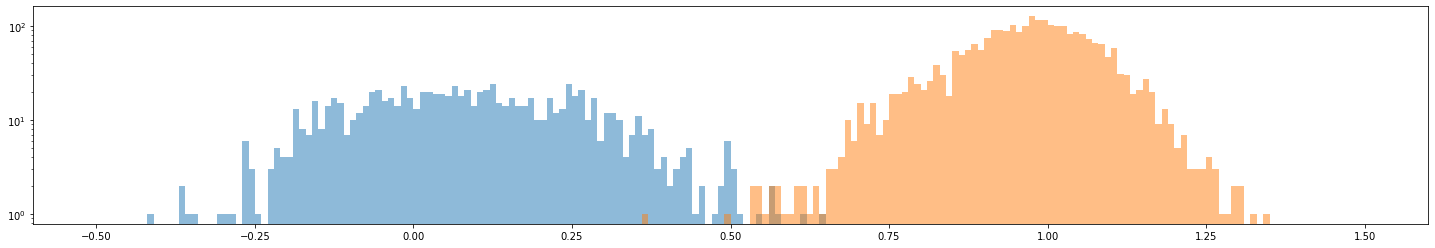

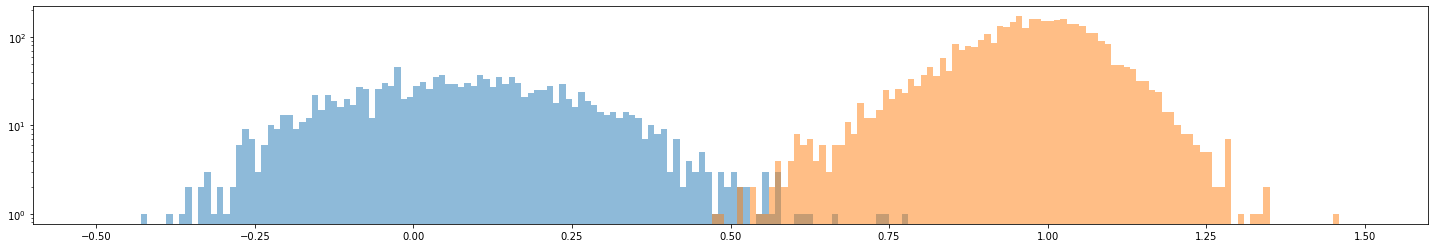

In [55]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_test[y_test.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==0]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model.predict(x_train[y_train.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()